In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader , Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
class CustomMNISTDataset(Dataset):
    def __init__(self,csv_file,transform=None,is_test=False):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform
        self.is_test = is_test

    
    def __len__(self):
        return len(self.data_frame)  #return the total number of samples in the dataset.
    
    def __getitem__(self, index):
        item = self.data_frame.iloc[index]

        if self.is_test:
            image = item.values.reshape(28,28).astype(np.uint8)
            label = None
        else:
            image = item[1:].values.reshape(28,28).astype(np.uint8)
            label = item.iloc[0]

        image = transforms.ToPILImage()(image)

        if self.transform is not None:
            image = self.transform(image)

        if self.is_test:
            return image
        else:
            return image,label

In [4]:
transform = transforms.Compose(
    [transforms.RandomRotation(15),
     transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5),)]
)

In [5]:
train_dataset = CustomMNISTDataset(csv_file='train.csv',transform=transform,is_test=False)
test_dataset = CustomMNISTDataset(csv_file='test.csv',transform=transform,is_test=True)

In [6]:
print(f"Train Size: {len(train_dataset)} Test Size: {len(test_dataset)}")

Train Size: 42003 Test Size: 28000


In [7]:
train_dataset[1]

(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.000

In [8]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False) # num_workers=2 slows down the training

input size: torch.Size([1, 28, 28])


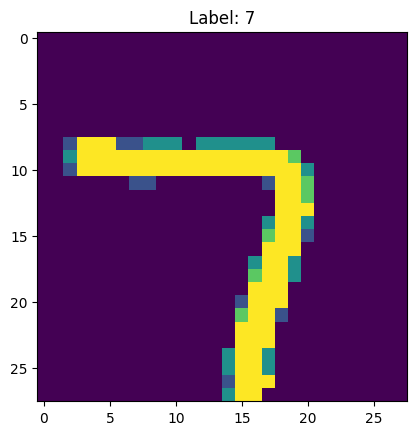

In [9]:
for example_data, example_label in train_loader:
    example_image = example_data[0]
    print(f"input size: {example_image.size()}")
    example_image_numpy = example_image.permute(1, 2, 0).numpy()
    plt.imshow(example_image_numpy)
    plt.title(f"Label: {example_label[0]}")
    plt.show()

    break

In [10]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.cov1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=1)
        self.cov2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.cov3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=1)

        # Update the input size for fc1
        self.fc1 = nn.Linear(128 * 26 * 26, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 20)
        self.fc3 = nn.Linear(20, 10)

    def forward(self, x): 
        x = self.cov1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.cov2(x)
        x = self.cov3(x)
        x = self.pool(x)

        # Flatten
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

In [11]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)   # Stochastic Gradient Descent


In [ ]:
num_epochs = 100
running_loss = 0.0

for epoch in range(num_epochs):
    for i , data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f"Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 100:.4f}")
            running_loss = 0.0

print("Finished Training")


Epoch: 1, Batch: 100, Loss: 1.9346
Epoch: 1, Batch: 200, Loss: 0.6281
Epoch: 1, Batch: 300, Loss: 0.4043
Epoch: 1, Batch: 400, Loss: 0.3683
Epoch: 2, Batch: 100, Loss: 0.3530
Epoch: 2, Batch: 200, Loss: 0.2734
Epoch: 2, Batch: 300, Loss: 0.2505
Epoch: 2, Batch: 400, Loss: 0.2339
Epoch: 3, Batch: 100, Loss: 0.2702
Epoch: 3, Batch: 200, Loss: 0.1815
Epoch: 3, Batch: 300, Loss: 0.1751
Epoch: 3, Batch: 400, Loss: 0.1739
Epoch: 4, Batch: 100, Loss: 0.1903
Epoch: 4, Batch: 200, Loss: 0.1479
Epoch: 4, Batch: 300, Loss: 0.1385
Epoch: 4, Batch: 400, Loss: 0.1479
Epoch: 5, Batch: 100, Loss: 0.2031
Epoch: 5, Batch: 200, Loss: 0.1450
Epoch: 5, Batch: 300, Loss: 0.1265
Epoch: 5, Batch: 400, Loss: 0.1114
Epoch: 6, Batch: 100, Loss: 0.1430
Epoch: 6, Batch: 200, Loss: 0.1091
Epoch: 6, Batch: 300, Loss: 0.1059
Epoch: 6, Batch: 400, Loss: 0.1017
Epoch: 7, Batch: 100, Loss: 0.1256
Epoch: 7, Batch: 200, Loss: 0.0941
Epoch: 7, Batch: 300, Loss: 0.0999
Epoch: 7, Batch: 400, Loss: 0.0904
Epoch: 8, Batch: 100

In [ ]:
#save the model 
torch.save(model.state_dict(), 'model.pth')